# Performance tips

## Topics
- Why Julia is fast
- LLVM compiler
- Parallellization

## Why is Julia fast?
- Rich type information, provided naturally by multiple dispatch
- Aggressive code specialization against run-time types
- JIT compilation using the LLVM compiler framework

In short, Julia is designated from the beginning to be fast. Not vice versa.

See the [scientific paper](https://arxiv.org/pdf/1209.5145v1.pdf) behind Julia, if you want to learn more.

## Optimizing nested loops: index "convention"

Julia is a column-major programming language. The inner loop should concern rows rather than columns. This is due to how arrays are stored in memory.

What this means is: **first index changes fastest**.
```julia
for k in 1:Nz
    for j in 1:Ny
        for i in 1:Nx
            arr[i,j,k]
        end
    end
end
```

In [1]:
# This function is badly written, because it looks at every column of a row, then at 
# every column of the next row, and so on

function laplacian_bad(lap_x::Array{Float64,2}, x::Array{Float64,2})
    nr,nc = size(x)
    for ir = 2:nr-1 
        for ic = 2:nc-1 # bad loop nesting order
            lap_x[ir,ic] =
                (x[ir+1,ic] + x[ir-1,ic] +
                x[ir,ic+1] + x[ir,ic-1]) - 4*x[ir,ic]
        end
    end
end

laplacian_bad (generic function with 1 method)

In [2]:
# In this version, the two loops are nested properly:

function laplacian_good(lap_x::Array{Float64,2}, x::Array{Float64,2})
    nr,nc = size(x)
    for ic = 2:nc-1
        for ir = 2:nr-1 # good loop nesting order
            lap_x[ir,ic] =
                (x[ir+1,ic] + x[ir-1,ic] +
                x[ir,ic+1] + x[ir,ic-1]) - 4*x[ir,ic]
        end
    end
end

laplacian_good (generic function with 1 method)

## Let's see the effect in practise!

In [3]:
using Printf
function main_test(nr, nc)
    field = zeros(nr, nc)
    for ic = 1:nc, ir = 1:nr
        if ir == 1 || ic == 1 || ir == nr || ic == nc
            field[ir,ic] = 1.0
        end
    end
    lap_field = zeros(size(field))

    time = @elapsed laplacian_bad(lap_field, field)
    @printf "laplacian_bad:          %.3f s\n" time
    
    time = @elapsed laplacian_good(lap_field, field)
    @printf "laplacian_good:         %.3f s\n" time

end
main_test(10^4, 10^4)

laplacian_bad:          3.375 s
laplacian_good:         0.093 s


## Levels of parallellism
1. Instruction level parallellism
2. Vector instructions (see `Bonus_simd-vectorization.pynb` if you are interested)
3. **Threading** (shared-memory)
4. **Distributed**
5. Accelerators (e.g., GPGPU; *not covered here*)

## Advanced: A (very short) introduction to the interiors of Julia compiler

Let's stop treating our tools like blackboxes. Let's see what the compiler herself is thinking about our code with `using InteractiveUtils`.

1. `@code_lowered`
2. `@code_typed` and `@code_warntype`
3. `@code_llvm`
4. `@code_native`

See [slides](https://slides.com/valentinchuravy/julia-parallelism) by Valentin Churavy, for more.

In [4]:
function mysum(A)
    acc = zero(eltype(A))
    for a in A
        acc += a
    end
    return acc
end

mysum (generic function with 1 method)

In [5]:
using InteractiveUtils

In [6]:
@code_lowered mysum(ones(1))

CodeInfo(
1 ─ %1  = Main.eltype(A)
│         acc = Main.zero(%1)
│   %3  = A
│         @_3 = Base.iterate(%3)
│   %5  = @_3 === nothing
│   %6  = Base.not_int(%5)
└──       goto #4 if not %6
2 ┄ %8  = @_3
│         a = Core.getfield(%8, 1)
│   %10 = Core.getfield(%8, 2)
│         acc = acc + a
│         @_3 = Base.iterate(%3, %10)
│   %13 = @_3 === nothing
│   %14 = Base.not_int(%13)
└──       goto #4 if not %14
3 ─       goto #2
4 ┄       return acc
)

In [7]:
@code_typed mysum(ones(1))

CodeInfo(
1 ── %1  = Base.bitcast(UInt64, 1)::UInt64
│    %2  = Base.sub_int(%1, 0x0000000000000001)::UInt64
│    %3  = Base.arraylen(A)::Int64
│    %4  = Base.sle_int(0, %3)::Bool
│    %5  = Base.bitcast(UInt64, %3)::UInt64
│    %6  = Base.ult_int(%2, %5)::Bool
│    %7  = Base.and_int(%4, %6)::Bool
└───       goto #3 if not %7
2 ── %9  = Base.arrayref(false, A, 1)::Float64
│    %10 = Base.add_int(1, 1)::Int64
└───       goto #4
3 ──       goto #4
4 ┄─ %13 = φ (#2 => false, #3 => true)::Bool
│    %14 = φ (#2 => %9)::Float64
│    %15 = φ (#2 => %10)::Int64
└───       goto #5
5 ── %17 = Base.not_int(%13)::Bool
└───       goto #11 if not %17
6 ┄─ %19 = φ (#5 => %14, #10 => %35)::Float64
│    %20 = φ (#5 => %15, #10 => %36)::Int64
│    %21 = φ (#5 => 0.0, #10 => %22)::Float64
│    %22 = Base.add_float(%21, %19)::Float64
│    %23 = Base.bitcast(UInt64, %20)::UInt64
│    %24 = Base.sub_int(%23, 0x0000000000000001)::UInt64
│    %25 = Base.arraylen(A)::Int64
│    %26 = Base.sle_int(0, %25)::Bo

In [8]:
@code_llvm mysum(ones(1))

;  @ c:\Projects\julia-introduction\notebooks\08_performance.ipynb:1 within `mysum`
; Function Attrs: uwtable
define

 double @julia_mysum_1285({}* noundef nonnull align 16 dereferenceable(40) %0) #0 {
top:
;  @ c:\Projects\julia-introduction\notebooks\08_performance.ipynb:3 within `mysum`
; ┌ @ array.jl:945 within `iterate` @ array.jl:945
; │┌ @ essentials.jl:10 within `length`
    %1 = bitcast {}* %0 to { i8*, i64, i16, i16, i32 }*
    %arraylen_ptr = getelementptr inbounds { i8*, i64, i16, i16, i32 }, { i8*, i64, i16, i16, i32 }* %1, i64 0, i32 1
    %arraylen = load i64, i64* %arraylen_ptr, align 8
; │└
; │┌ @ int.jl:520 within `<` @ int.jl:513
    %.not = icmp eq i64 %arraylen, 0
; │└
   br i1 %.not, label %L41, label %L17

L17:                                              ; preds = %top
; │┌ @ essentials.jl:13 within `getindex`
    %2 = bitcast {}* %0 to double**
    %arrayptr18 = load double*, double** %2, align 8
    %arrayref = load double, double* %arrayptr18, align 8
; └└
;  @ c:\Projects\julia-introduction\notebooks\08_performance.ipynb:4 within `mysum`
; ┌ @ float.jl:409 within `+`
   %3 

%L35.preheader

L35.preheader:                                    ; preds = %L17
   %4 = add nsw i64 %arraylen, -1
   %5 = add nsw i64 %arraylen, -2
   %xtraiter = and i64 %4, 7
   %6 = icmp ult i64 %5, 7
   br i1 %6, label %L41.loopexit.unr-lcssa, label %L35.preheader.new

L35.preheader.new:                                ; preds = %L35.preheader
   %unroll_iter = and i64 %4, -8
   br label %L35

L35:                                              ; preds = %L35, %L35.preheader.new
   %7 = phi i64 [ 1, %L35.preheader.new ], [ %28, %L35 ]
   %8 = phi double [ %3, %L35.preheader.new ], [ %32, %L35 ]
   %value_phi426 = phi i64 [ 2, %L35.preheader.new ], [ %31, %L35 ]
   %niter = phi i64 [ 0, %L35.preheader.new ], [ %niter.next.7, %L35 ]
; │┌ @ essentials.jl:13 within `getindex`
    %9 = getelementptr inbounds double, double* %arrayptr18, i64 %7
    %arrayref10 = load double, double* %9, align 8
; │└
; │┌ @ int.jl:87 within `+`
    %10 = or i64 %value_phi426, 1
; └└
;  @ c:\Projects\julia-i

 2, %L35.preheader ], [ %31, %L35 ]
   %lcmp.mod.not = icmp eq i64 %xtraiter, 0
   br i1 %lcmp.mod.not, label %L41, label %L35.epil

L35.epil:                                         ; preds = %L35.epil, %L41.loopexit.unr-lcssa
   %33 = phi i64 [ %value_phi426.epil, %L35.epil ], [ %.unr, %L41.loopexit.unr-lcssa ]
   %34 = phi double [ %37, %L35.epil ], [ %.unr28, %L41.loopexit.unr-lcssa ]
   %value_phi426.epil = phi i64 [ %36, %L35.epil ], [ %value_phi426.unr, %L41.loopexit.unr-lcssa ]
   %epil.iter = phi i64 [ %epil.iter.next, %L35.epil ], [ 0, %L41.loopexit.unr-lcssa ]
; │┌ @ essentials.jl:13 within `getindex`
    %35 = getelementptr inbounds double, double* %arrayptr18, i64 %33
    %arrayref10.epil = load double, double* %35, align 8
; │└
; │┌ @ int.jl:87 within `+`
    %36 = add nuw nsw i64 %value_phi426.epil, 1
; └└
;  @ c:\Projects\julia-introduction\notebooks\08_performance.ipynb:4 within `mysum`
; ┌ @ float.jl:409 within `+`
   %37 = fadd double %arrayref10.epil, %34
; └
;  @ c

In [9]:
@code_native mysum(ones(1))

	.text
	.file	"mysum"
	.globl	julia_mysum_1320                # -- Begin function julia_mysum_1320
	.p2align	4, 0x90
	.type	julia_mysum_1320,@function
julia_mysum_1320:                       # @julia_mysum_1320
; ┌ @ c:\Projects\julia-introduction\notebooks\08_performance.ipynb:1 within `mysum`
	.cfi_startproc
# %bb.0:                                # %top
	push	rbp
	.cfi_def_cfa_offset 16
	.cfi_offset rbp, -16
	mov	rbp, rsp
	.cfi_def_cfa_register rbp
; │ @ c:\Projects\julia-introduction\notebooks\08_performance.ipynb:3 within `mysum`
; │┌ @ array.jl:945 within `iterate` @ array.jl:945
; ││┌ @ essentials.jl:10 within `length`
	mov	rdx, qword ptr [rcx + 8]
; ││└
; ││┌ @ int.jl:520 within `<` @ int.jl:513
	test	rdx, rdx
; ││└
	je	.LBB0_1
# %bb.2:                                # %L17
; ││┌ @ essentials.jl:13 within `getindex`
	mov	rax, qword ptr [rcx]
	vxorpd	xmm0, xmm0, xmm0
; │└└
; │ @ c:\Projects\julia-introduction\notebooks\08_performance.ipynb:4 within `mysum`
; │┌ @ float.jl:409 wi

## About global scope
So what does the previous machine code actually mean? Well, in practise:

A global variable might have its value, and therefore its type, change at any given point. This makes it difficult/nigh impossible for the compiler to reason about/optimize code using global variables.

Julia uses functions as its compilation unit and any code that is performance critical or being benchmarked should be inside a function.

## Demo: Giving hints to the compiler 
Let's see what we can do with our previously defined `laplacian` function. 

For some aggressive cases we can provide the JIT-compiler `@inbounds` macro hinting that there is no need to check array bounds.

In [10]:
#Lets re-define our previous Laplacians (from 05_ notebook)
function laplacian_bad(lap_x::Array{Float64,2}, x::Array{Float64,2})
    nr,nc = size(x)
    for ir = 2:nr-1, ic = 2:nc-1 # bad loop nesting order
        lap_x[ir,ic] =
            (x[ir+1,ic] + x[ir-1,ic] +
            x[ir,ic+1] + x[ir,ic-1]) - 4*x[ir,ic]
    end
end

#In this version, the two loops are nested properly:
function laplacian_good(lap_x::Array{Float64,2}, x::Array{Float64,2})
    nr,nc = size(x)
    for ic = 2:nc-1, ir = 2:nr-1 # good loop nesting order
        lap_x[ir,ic] =
            (x[ir+1,ic] + x[ir-1,ic] +
            x[ir,ic+1] + x[ir,ic-1]) - 4*x[ir,ic]
    end
end

laplacian_good (generic function with 1 method)

In [11]:
# A way to increase the speed is to remove the array bounds checking, using the macro @inbounds:
function laplacian_good_nocheck(lap_x::Array{Float64,2}, x::Array{Float64,2})
    nr,nc = size(x)
    for ic = 2:nc-1
        for ir = 2:nr-1 # good loop nesting order
            @inbounds begin lap_x[ir,ic] = # no array bounds checking
                (x[ir+1,ic] +  x[ir-1,ic] +
                x[ir,ic+1] + x[ir,ic-1]) - 4*x[ir,ic]
            end
        end
    end
end

laplacian_good_nocheck (generic function with 1 method)

In [12]:
using Printf #evaluate me to get printf

In [15]:
function main_test(nr, nc)
    field = zeros(nr, nc)
    for ic = 1:nc, ir = 1:nr
        if ir == 1 || ic == 1 || ir == nr || ic == nc
            field[ir,ic] = 1.0
        end
    end
    lap_field = zeros(size(field))

    time = @elapsed laplacian_bad(lap_field, field)
    @printf "laplacian_bad:          %.3f s\n" time
    
    time = @elapsed laplacian_good(lap_field, field)
    @printf "laplacian_good:         %.3f s\n" time
    
    time = @elapsed laplacian_good_nocheck(lap_field, field)
    @printf "laplacian_good_nocheck: %.3f s\n" time
end

main_test(10^4, 10^4)

laplacian_bad:          2.697 s


laplacian_good:         0.096 s
laplacian_good_nocheck: 0.100 s


## Threading (experimental)
Julia threading model is based on a fork-join approach and is still considered experimental.

Fork-join describes the control flow that a group of threads undergoes. Execution is then forked and an anonymous function is ran across all threads.

All threads have to join together and serial execution continues.

## Threading in practise
The number of threads Julia starts up with is controlled by an environment variable called `JULIA_NUM_THREADS`. Now, let's start up Julia with 4 threads:

```bash
export JULIA_NUM_THREADS=4
julia
```
Or in Windows:
```powershell
$env:JULIA_NUM_THREADS = "4"
julia
```

```cmd
set JULIA_NUM_THREADS=4
julia
```

NOTE: this does not work in the notebook environment because the kernel is automatically loaded with only 1 thread.

In [16]:
using Base.Threads
nthreads()

1

## Using threads

```julia
@threads for id in 1:nthreads()
    #each thread does something
end
```

In [ ]:
a = zeros(10)
@threads for i = 1:10
    a[i] = Threads.threadid()
end
a

## Advanced: Threaded sum
Here is a more complex example of threaded sum from https://github.com/stevengj/18S096/blob/master/lectures/lecture5/Parallelism.ipynb

In [18]:
function threaded_sum(arr)
   @assert length(arr) % nthreads() == 0
    
   let results = zeros(eltype(arr), nthreads())
       @threads for tid in 1:nthreads()
           # split work
           acc = zero(eltype(arr))
           len = div(length(arr), nthreads())
           domain = ((tid-1)*len +1):tid*len
           @inbounds for i in domain
               acc += arr[i]    
           end
           results[tid] = acc
       end
       sum(results)
   end
end

threaded_sum (generic function with 1 method)

## Distributed computing 
Distributed processing uses individual processes that communicate with each other. In this case, data movement and communication is explicit!

Julia supports various forms of distributed computing. 
- **A native master-worker system based on remote procedure calls**
- MPI through [MPI.jl](https://github.com/JuliaParallel/MPI.jl)
- [DistributedArrays.jl](https://github.com/JuliaParallel/DistributedArrays.jl)

## Master-Worker model
We need to launch Julia with 
```bash
julia -p 4
```
then inside Julia you can check
```julia
nprocs()
workers()
```
which should print `5` and `[2,3,4,5]`. 

Why 5, you ask? Because *"worker 1"* is the *"boss"*. And bosses don't work.

Functions (and everything used by workers) needs to be explicitly declared for all:
```julia
@everywhere g(x) = 2x
```
Only then can we send the job to somebody else and fetch the result
```julia
remotecall_fetch(g, 3, 2.0)
```
Here we fetch the result of `g` of worker `3` applied to a value of `2.0`.

Use `@everywhere` to execute a top-level block on each process
```julia
@everywhere begin
    using Test
    include("src.jl")
end
```
Define variables on all processes
```julia
@everywhere bar = 1
```


## `@distributed` as a shortcut 
A parallel for loop of the form (from `using Distributed`):
```julia
@distributed [reducer] for var = range
    body
end
```
The specified range is partitioned and locally executed across all workers. In case an optional reducer function is specified, `@distributed` performs local reductions on each worker with a final reduction on the calling process.

Note that without a reducer function, `@distributed` executes asynchronously, i.e., it spawns independent tasks on all available workers and returns immediately without waiting for completion. To wait for completion, prefix the call with `@sync`, like :
```julia
@sync @distributed for var = range
      body
end
```

In [19]:
using Distributed

nheads = @distributed (+) for i=1:200000000
  Int(rand(Bool))
end

100008488

## pmap for unbalanced load
In some cases no reduction operator is needed, and we merely wish to apply a function to all integers in some range. This is another useful operation called parallel map. 

For example, we could compute the singular values of several large random matrices in parallel as follows:

In [20]:
using LinearAlgebra #loading svd()

In [21]:
M = Matrix{Float64}[rand(1000,1000) for i=1:10]
pmap(svd, M)

10-element Vector{SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}}:
 SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}([-0.03063554945409852 0.0717037063305702 … 0.011572928844591487 -0.02022042707519078; -0.03191932936924713 0.028609635207559596 … -0.026897658875181422 0.05238973727359938; … ; -0.031047478484075974 0.004250268392122387 … -0.0008754868071139386 -0.021433266763823816; -0.032379720697495194 -0.02785424714123289 … 0.07020117559961359 0.0023687721940921108], [500.32486265081366, 18.18273858601528, 18.07421644404916, 17.965197203716105, 17.930631957944556, 17.833789719736853, 17.80919847233776, 17.72757214949603, 17.718852968914096, 17.694956775359575  …  0.13045738678715948, 0.11972942192572689, 0.11384803614658769, 0.0943348815754649, 0.0837734207851691, 0.06506756827105792, 0.05573692725038404, 0.05314171290252604, 0.012043700205546804, 0.007048629320308829], [-0.03161186090774618 -0.032028916657162676 … -0.03235678524684803 -0.031294835425152136; 0.0300641

`pmap()` is designed for the case where each function call does a large amount of work. In contrast, `@distributed for` can handle situations where each iteration is tiny, perhaps merely summing two numbers.

### Exercise 1: π in parallel

Let's compute the value of π=3.1415926.... in parallel using Monte Carlo simulations.

Below is a function that does this by throwing darts inside a box of $[-1, 1]^2$. It follows from the definition of π that the area fo a circle is $A = \pi r^2$, where $r$ is the radius of a circle. We develop a Monte Carlo algorithm to compute π by randomly throwing darts (i.e., generating uniformly distributed random numbers inside a unit box) and counting the fraction of the points that land inside the circle.

Let's try to visualize the setup first. 

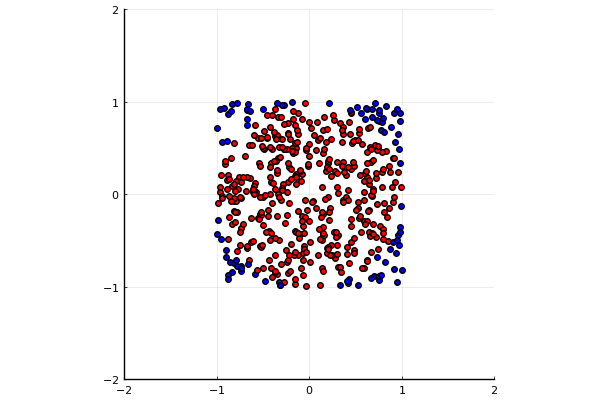

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [22]:
using Plots
pyplot()

plt = plot( xlims=(-2,2), ylims=(-2,2), aspect_ratio=1)
for n in 1:500
    x = rand()*2 - 1
    y = rand()*2 - 1
    
    r = sqrt(x^2 + y^2)
    if r < 1
        #inside
        scatter!([x], [y], color="red", label="")
    else
        #outside
        scatter!([x], [y], color="blue",label="")
    end
end
plt #display plot

Can you see the circle? Now, let's do some actual computing.

In [40]:
function compute_pi(N::Int)
    n_landed_in_circle = 0  # counts number of points that have radial coordinate < 1, i.e. in circle
    for i = 1:N
        x = rand() * 2 - 1  # uniformly distributed number on x-axis
        y = rand() * 2 - 1  # uniformly distributed number on y-axis

        r = sqrt(x*x + y*y)  # radius squared, in radial coordinates
        if r < 1
            n_landed_in_circle += 1
        end
    end

    return n_landed_in_circle / N * 4.0    
end


compute_pi (generic function with 1 method)

The time macro is a quick way to benchmark the performance of our code.

In [41]:
@time compute_pi(10^9)

  3.400192 seconds


3.14153916

#### Actual exercise
Your mission? Parallellize the `compute_pi` function! 

Hint: see the `for` loop? Remember `@distributed`? Remember that when using `@distributed` the result of each iteration is taken as the value of the last expression inside the loop. Therefore if your loops ends in
```julia
for 
    #blaablaa
    #...
    if something
        1
    else
        0
    end
end
```
it will result in returning either `1` or `0`.

You can also try adapting this to use `pmap` if you like. 

Remember to add workers before we run our sweet new function with this command:

In [42]:
using Distributed
addprocs(4)
nprocs()

13

In [45]:
function compute_pi_distr(N::Int)
    n_landed_in_circle = 0  # counts number of points that have radial coordinate < 1, i.e. in circle
    n_landed_in_circle = @distributed (+) for i = 1:N
        x = rand() * 2 - 1  # uniformly distributed number on x-axis
        y = rand() * 2 - 1  # uniformly distributed number on y-axis

        r = sqrt(x*x + y*y)  # radius squared, in radial coordinates
        if r < 1
            1 #return +1 to the counts
        else
            0 #return 0 to the counts
        end
    end

    return n_landed_in_circle / N * 4.0    
end

compute_pi_distr (generic function with 1 method)

In [46]:
@time compute_pi_distr(10^9)

3.141521808

  1.123003 seconds (69.18 k allocations: 4.702 MiB, 3.98% compilation time)


Finally, after you are done, see the full story at [Parallel Monte Carlo in Julia](http://corysimon.github.io/articles/parallel-monte-carlo-in-julia/)

### Advanced Exercise 1: Distributed Arrays

Install `DistributedArrays` as
```julia
Pkg.add("DistributedArrays")
```

then try them out as
```julia
addprocs(4) #adding 4 workers to share the load
@everywhere using DistributedArrays #loading DAs for every worker
A = fill(1.1, (100, 100) ) #create array
DA = distribute(A) #distribute it to workers
sum(DA)
```

In [33]:
using Pkg
Pkg.add("DistributedArrays")
Pkg.status()

    Updating registry at `C:\Users\jiahuang\.julia\registries\SpineRegistry`


    Updating git-repo `https://github.com/Spine-project/SpineJuliaRegistry.git`


    Updating registry at `C:\Users\jiahuang\.julia\registries\General.toml`


   Resolving package versions...


   Installed DistributedArrays ─ v0.6.7


    Updating `C:\Projects\julia-introduction\Project.toml`
  [aaf54ef3] + DistributedArrays v0.6.7
    Updating `C:\Projects\julia-introduction\Manifest.toml`


  [aaf54ef3] + DistributedArrays v0.6.7
  [8ee5b7ce] + Epidemic v0.1.0 `notebooks\Epidemic`


Precompiling

project...

  ✓ DistributedArrays


Status `C:\Projects\julia-introduction\Project.toml`
  [5ae59095] Colors v0.12.10
  [aaf54ef3] DistributedArrays v0.6.7
  [7073ff75] IJulia v1.24.2
  [033835bb] JLD2 v0.4.46
  [a0a80e5a] MyPackage v0.1.0 `notebooks\MyPackage`
  [f0f68f2c] PlotlyJS v0.18.12
  [91a5bcdd] Plots v1.40.1
  [27ebfcd6] Primes v0.5.5
  [438e738f] PyCall v1.96.4
  [d330b81b] PyPlot v2.11.2


  1 dependency successfully precompiled in 7 seconds. 188 already precompiled.


In [34]:
addprocs(4) #adding 4 workers to share the load
@everywhere using DistributedArrays #loading DAs for every worker
A = fill(1.1, (100, 100) ) #create array
DA = distribute(A) #distribute it to workers
sum(DA)

11000.000000000013

### Advanced Exercise 2: MPI

Install `MPI` package by running:
```julia
Pkg.update()
Pkg.add("MPI")
```
In case of problems, see the [readme](https://github.com/JuliaParallel/MPI.jl)

Because of how MPI works, we need to explicitly write our code into a file. Create `01-hello.jl` and `01-hello-impl.jl` as follows:

`01-hello.jl` should look like this:
```julia

import MPI
include("01-hello-impl.jl")

function main()
    MPI.Init()

    do_hello()

    MPI.Finalize()
end

main()
```
and the actual implementation file `01-hello-impl.jl` like this
```julia

function do_hello()
    comm = MPI.COMM_WORLD
    println("Hello world, I am $(MPI.Comm_rank(comm)) of $(MPI.Comm_size(comm))")
    MPI.Barrier(comm)
end
```


You can execute your code the normal way as
```bash
mpirun -np 3 julia 01-hello.jl
```

See the MPI.jl [examples](https://github.com/JuliaParallel/MPI.jl/tree/master/examples) for more.

## Summary: General optimization tricks

- Write functions!
- Avoid global variables
    - A global variable might have its value, (and type) change at any given point. This makes it hard for the compiler to optimize.